In [1]:
import sys, os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
sys.path.append(os.path.abspath(os.path.join('../../../BayesFlow')))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial
import pickle

import tensorflow as tf

In [2]:
from bayesflow import benchmarks
from bayesflow.amortizers import AmortizedPosterior, AmortizedLikelihood, AmortizedPosteriorLikelihood
from bayesflow.networks import InvertibleNetwork
from bayesflow.trainers import Trainer
from bayesflow.diagnostics import plot_sbc_ecdf, plot_recovery, plot_posterior_2d, plot_losses, plot_latent_space_2d

/Users/marvin/miniforge3/envs/bf/lib/python3.10/site-packages/bayesflow/trainers.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from tensorflow_probability import distributions as tfd

# Benchmark: Lotka-Volterra

In [4]:
benchmark_name = 'lotka_volterra'
benchmark = benchmarks.Benchmark(benchmark_name)

INFO:root:Performing 2 pilot runs with the lotka_volterra model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 4)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 20)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional simulation batchable context provided.


# Amortizer and Trainer
Note, do not try this at home! :)

The LV likelihood generates nearly-deterministic time series, so it should be modeled with a recurrent likelihood. However, we stick to the original formulation in Lueckmann et al. (2021), which uses data at 20 uniformly sampled time points and treats it as a 20-dimensional vector instead of a time series of 20 scalars.

In [5]:
# No summary net, mock
summary_net = lambda x, **kwargs: x

# Robust inference with a Student-T latent
latent_dist_p = tfd.MultivariateStudentTLinearOperator(
    df=50, loc=[0.]*4, scale=tf.linalg.LinearOperatorDiag([1.]*4))
latent_dist_l = tfd.MultivariateStudentTLinearOperator(
    df=50, loc=[0.]*20, scale=tf.linalg.LinearOperatorDiag([1.]*20))


coupling_settings = {
    'affine': {
        'dense_args': dict(units=128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
        'dropout_prob': 0.05
    },
    'spline': {
        'dense_args': dict(units=128, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(1e-5)),
        'dropout_prob': 0.05
    }
}

# Inference networks
inference_net_p = InvertibleNetwork(
    num_params=4, 
    num_coupling_layers=6,
    coupling_design='interleaved',
    coupling_settings=coupling_settings
)

inference_net_l = InvertibleNetwork(
    num_params=20, 
    num_coupling_layers=8,
    coupling_design='interleaved',
    coupling_settings=coupling_settings,
)

# Amortizers
amortized_posterior = AmortizedPosterior(
    inference_net=inference_net_p,
    summary_net=summary_net,
    latent_dist=latent_dist_p
)

amortized_likelihood = AmortizedLikelihood(
    surrogate_net=inference_net_l,
    latent_dist=latent_dist_l
)

amortizer = AmortizedPosteriorLikelihood(
    amortized_posterior, 
    amortized_likelihood
)

In [6]:
trainer = Trainer(
    amortizer=amortizer,
    default_lr=1e-3,
    generative_model=benchmark.generative_model,
    configurator=partial(benchmark.configurator, as_summary_condition=True),
    checkpoint_path=f'checkpoints/{benchmark_name}',
    memory=False,
    max_to_keep=1
)

INFO:root:Loaded loss history from checkpoints/lotka_volterra/history_150.pkl.
INFO:root:Networks loaded from checkpoints/lotka_volterra/ckpt-150
INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


# Training
Uncomment for training. Wall time on GPU: 45min 58s

In [7]:
# EPOCHS = 150
# SIMULATION_BUDGET = 10000
# N_VAL = 300
# BATCH_SIZE = 64

# train_data = trainer.generative_model(SIMULATION_BUDGET)

In [8]:
# %%time
# h = trainer.train_offline(train_data, EPOCHS, BATCH_SIZE, validation_sims=N_VAL)

# Validation

## Loss Trajectories

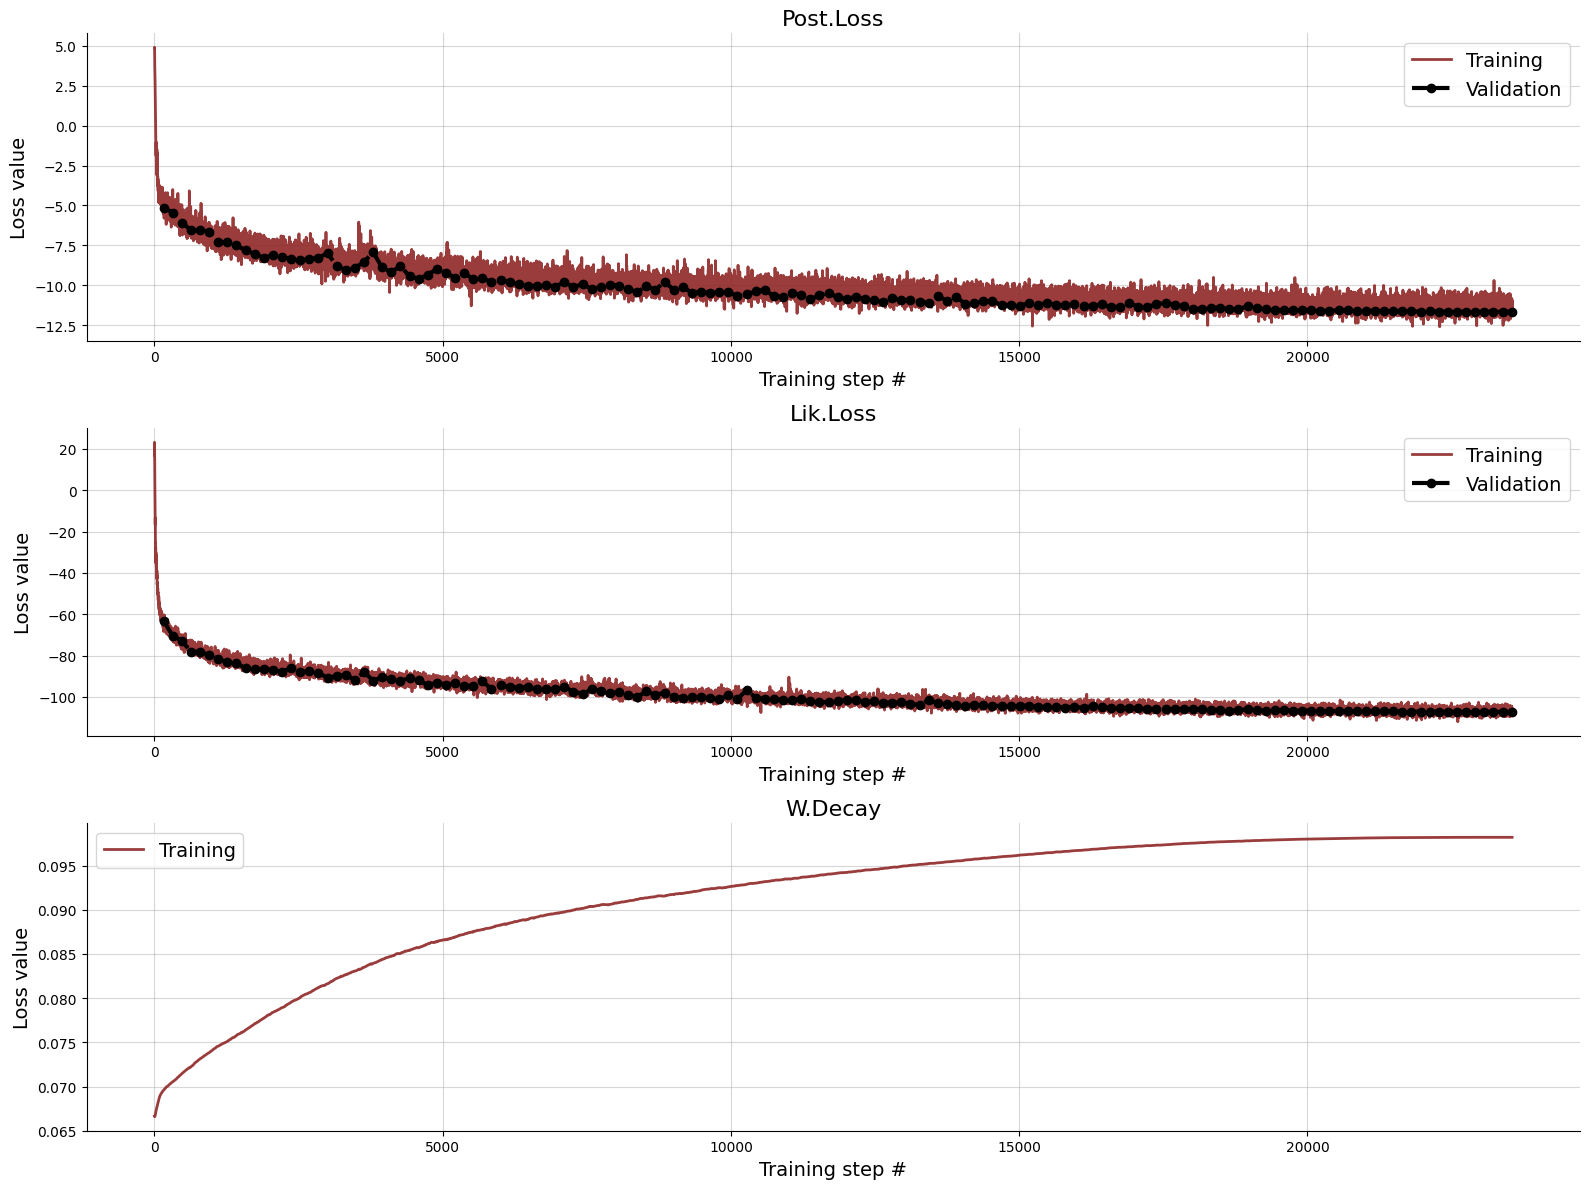

In [9]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])

## Test (Held-Out) Data

In [10]:
# Load test data
with open(f'test_data/{benchmark_name}_test.pkl', 'rb') as f:
    test_dict = pickle.load(f)

In [11]:
# Simulate from surrogate simulator
x_sim_s = amortizer.sample_data(test_dict, n_samples=1)
x_sim_s = tf.squeeze(x_sim_s)

# Sample from posteriors given surrogate outputs
post_samples_s = amortizer.sample_parameters({'summary_conditions': x_sim_s}, n_samples=250)

# Sample from posteriors given simulator outputs
post_samples = amortizer.sample_parameters(test_dict, n_samples=250)

# Prior samples
prior_samples = test_dict['posterior_inputs']['parameters']

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


### Recovery

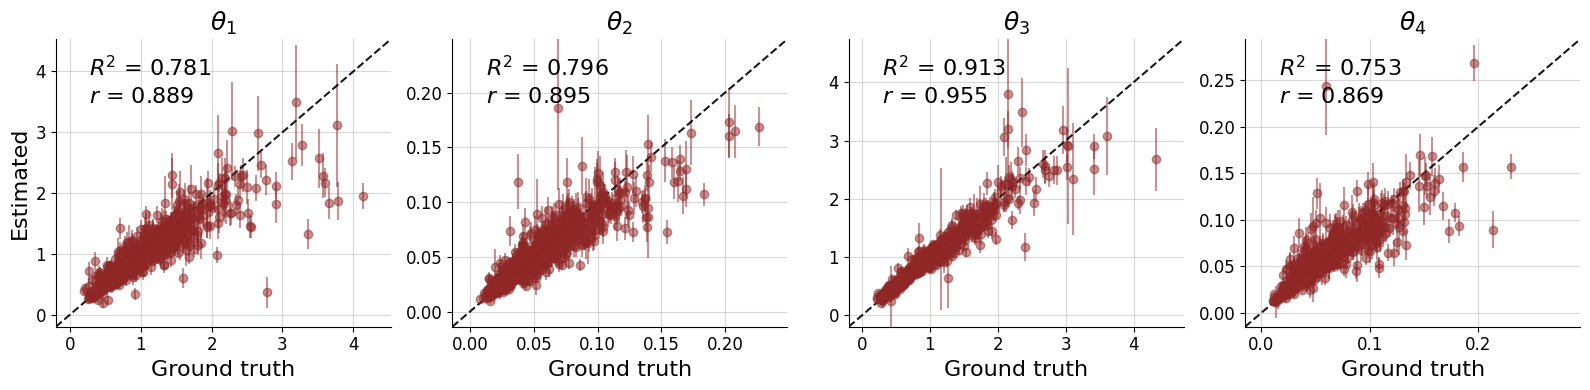

In [12]:
f = plot_recovery(post_samples, prior_samples)

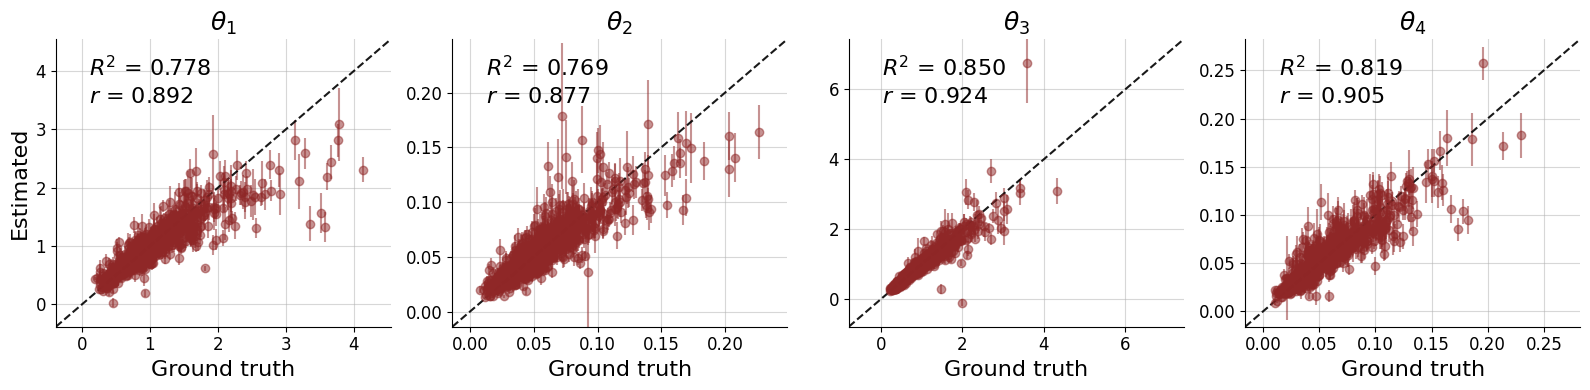

In [13]:
f = plot_recovery(post_samples_s, prior_samples)

# Appendix Plots

In [14]:
# load custom tighter plotting function
from custom_plots import plot_sbc_ecdf_appendix

# adjust for better readability
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    'text.latex.preamble' : r'\usepackage{{amsmath}}'
})

### Loss History

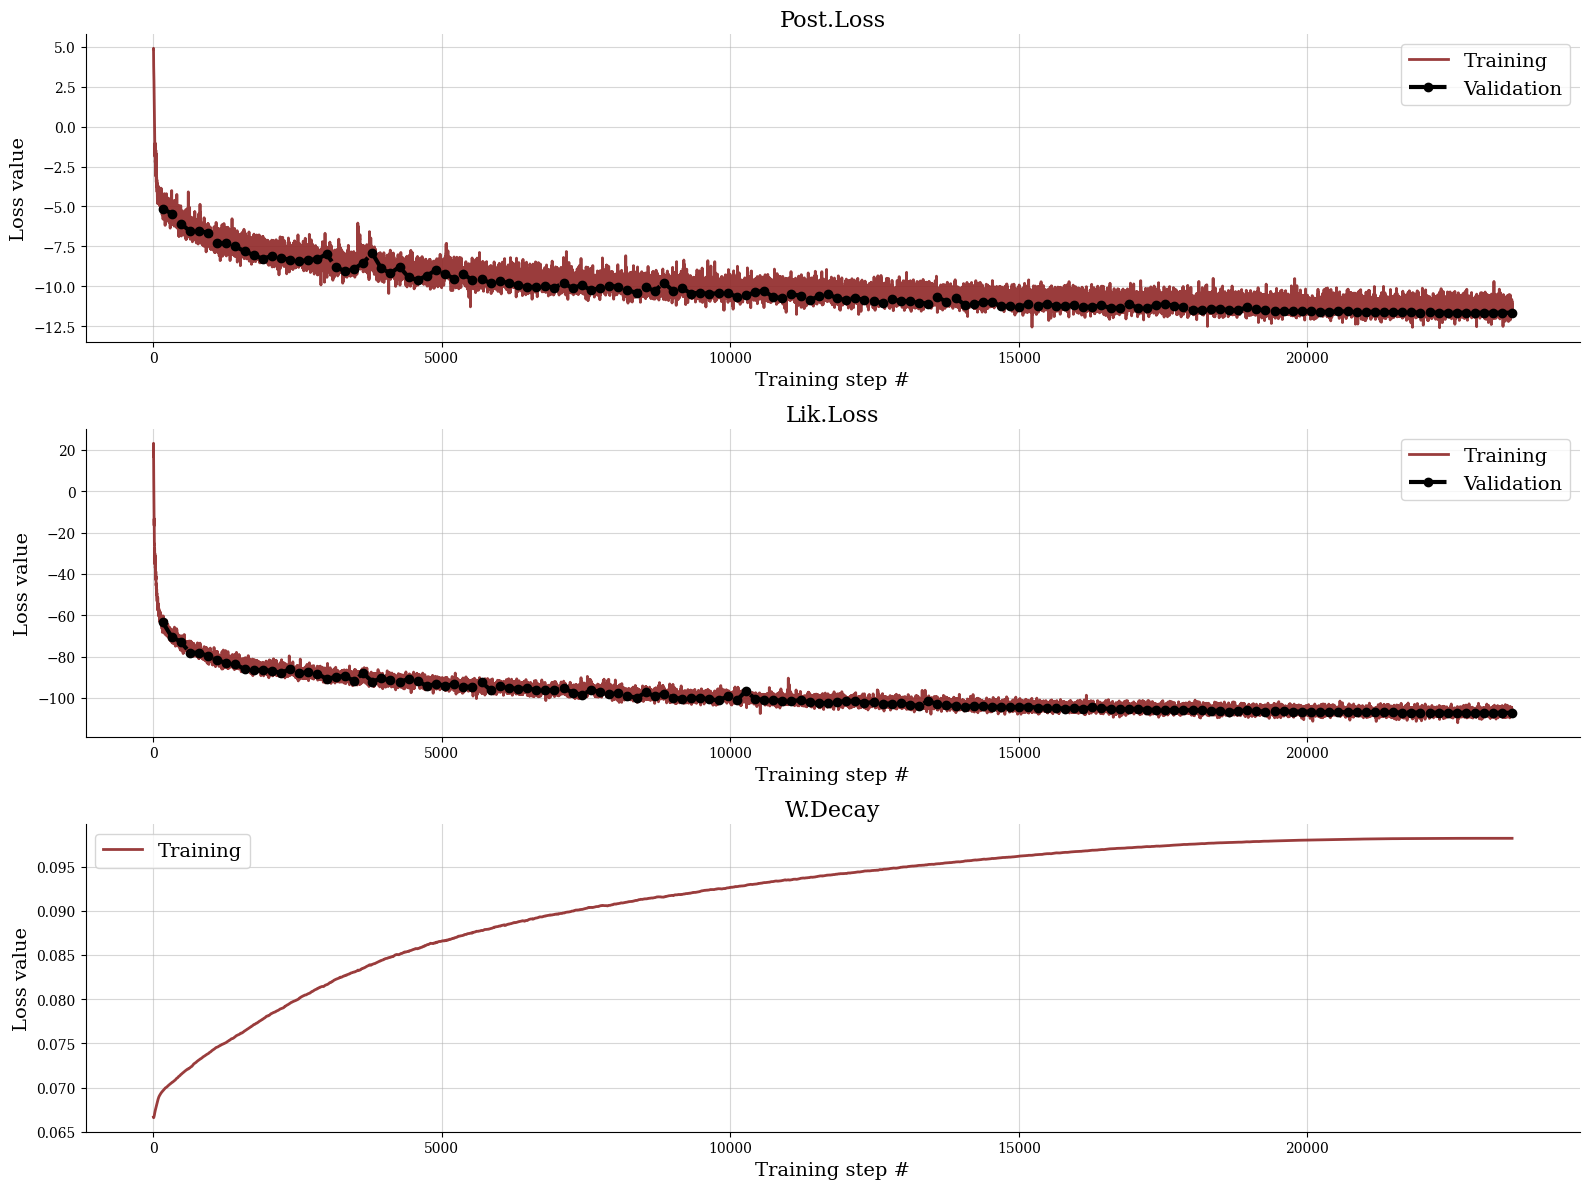

In [15]:
# Use loaded history, since reference 'h' will only exist after training
h = trainer.loss_history.get_plottable()
f = plot_losses(h['train_losses'], h['val_losses'])
plt.savefig(f"figures/{benchmark_name}_losses.pdf", dpi=300, bbox_inches="tight")

### Posterior Calibration

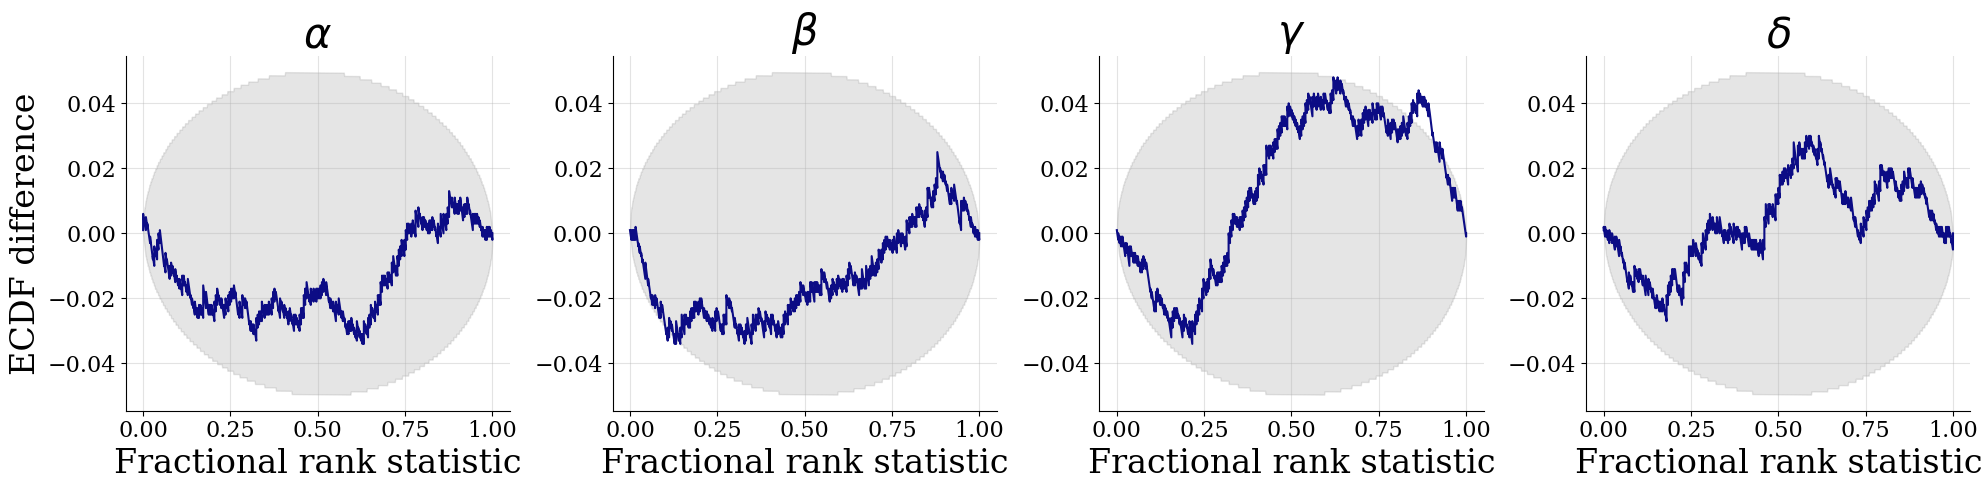

In [16]:
f = plot_sbc_ecdf_appendix(
    post_samples, 
    prior_samples, 
    ecdf_bands_kwargs=dict(confidence=0.95), 
    param_names=benchmark.benchmark_info['parameter_names'],
    label_fontsize=24, 
    legend_fontsize=24, 
    difference=True, 
    rank_ecdf_color='#000080'
)

plt.savefig(f"figures/{benchmark_name}_posterior_calibration_diff_separate.pdf", dpi=300, bbox_inches="tight")

### Joint Calibration

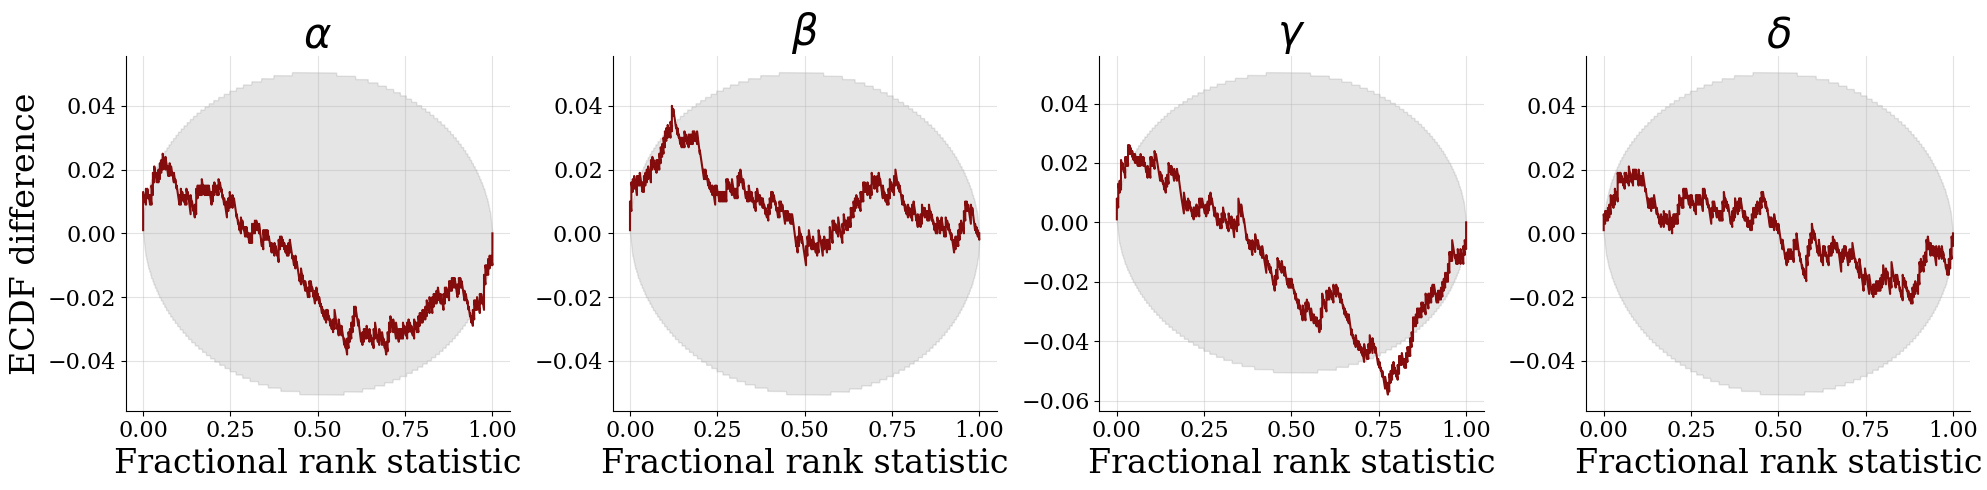

In [17]:
f = plot_sbc_ecdf_appendix(
    post_samples_s, 
    prior_samples, 
    ecdf_bands_kwargs=dict(confidence=0.95), 
    param_names=benchmark.benchmark_info['parameter_names'],
    label_fontsize=24, 
    legend_fontsize=24, 
    difference=True, 
    rank_ecdf_color='#800000'
)

plt.savefig(f"figures/{benchmark_name}_joint_calibration_diff_separate.pdf", dpi=300, bbox_inches="tight")